# Multi-armed Bandit Recommender System

## Env

In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import FeatureHasher
import random
import matplotlib.pyplot as plt

## Dataset

In [6]:
events = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\events.csv')
categories = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\category_tree.csv')
item_properties_part1 = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\item_properties_part1.csv')
item_properties_part2 = pd.read_csv(r'C:\Users\fldam\OneDrive\MBA\TCC\Code\Dataset\item_properties_part2.csv')

In [7]:
# Concatenate item_properties_part1 and item_properties_part2
properties = pd.concat([item_properties_part1, item_properties_part2], ignore_index=True)

## Data Exploring, Cleaning and Feature Engineering

### Events

#### Overall

In [26]:
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [27]:
# Check the size of the dataset
len(events)

2756101

In [28]:
# Check the data types of the columns
events.dtypes

timestamp          int64
visitorid          int64
event             object
itemid             int64
transactionid    float64
dtype: object

In [29]:
# Check null values in the events DataFrame
events.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid    2733644
dtype: int64

In [30]:
# Check if there are any duplicate entries in the events DataFrame
events[events.duplicated(keep='first')==True].shape[0]

460

In [31]:
# Drop duplicates
events.drop_duplicates(keep='first', inplace=True)

#### transactionid

Looks like transctionid is not null only for certain events

In [32]:
# Check transactionid non null values
events[~events['transactionid'].isnull()]

,timestamp,visitorid,event,itemid,transactionid
130,1433222276276,599528,transaction,356475,4000.0
304,1433193500981,121688,transaction,15335,11117.0
418,1433193915008,552148,transaction,81345,5444.0
814,1433176736375,102019,transaction,150318,13556.0
843,1433174518180,189384,transaction,310791,7244.0
...,...,...,...,...,...
2755294,1438377176570,1050575,transaction,31640,8354.0
2755349,1438379878779,861299,transaction,456602,3643.0
2755508,1438357730123,855941,transaction,235771,4385.0
2755603,1438355560300,548772,transaction,29167,13872.0


In [33]:
# Check the reason for the non null values in transactionid
events[~events['transactionid'].isnull()]['event'].unique()

array(['transaction'], dtype=object)

In [34]:
# Check if there are transactionid values that are null when the event is 'transaction'
events[events['event'] == 'transaction']['transactionid'].isnull().sum()

np.int64(0)

transactionid is not null only when the event is 'transaction'. For the dataset, transactionid is the amount spent in each event, so it makes sense to have it only when event is transaction

#### timestamp

Seems like timestamp is a Unix column. I am going to convert it to datetime

In [35]:
# Convert 'timestamp' to datetime format and sort by 'timestamp'
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms', origin='unix')
events.sort_values('timestamp', inplace=True)

In [36]:
# Check time range of events
timedelta = (events['timestamp'].iloc[-1]-events['timestamp'].iloc[0]).days
timedelta

137

#### event

In [37]:
# Check the type of events
events['event'].unique()

array(['addtocart', 'view', 'transaction'], dtype=object)

In [38]:
print("Number of transactions:",events[events['event'] == 'transaction'].shape[0])
print("Number of views:",events[events['event'] == 'view'].shape[0])
print("Number of addtocart:",events[events['event'] == 'addtocart'].shape[0])


Number of transactions: 22457
Number of views: 2664218
Number of addtocart: 68966


#### visitorid

In [39]:
# Check the number of unique visitors
events['visitorid'].unique().shape[0]

1407580

In [40]:
# Check how many unique visitors actually made a purchase
events[events['event'] == 'transaction']['visitorid'].unique().shape[0]

11719

In [41]:
# Check how many unique visitors added items to their cart
events[events['event'] == 'addtocart']['visitorid'].unique().shape[0]

37722

In [42]:
# Check if the same visitorid appears in both 'addtocart' and 'transaction' events
events[(events['event'] == 'addtocart') & 
       (events['visitorid']
        .isin(events[events['event'] == 'transaction']['visitorid']))]['visitorid'].unique().shape[0]

10576

In [43]:
# Check the visitorid that made a purchase but did not add items to their cart
events[(events['event'] == 'transaction') & 
       (events['visitorid']
        .isin(events[events['event'] == 'addtocart']['visitorid'])==False)]['visitorid'].unique().shape[0]

1143

In [44]:
# Check the visitorid that made a purchase but did not viewed any items
events[(events['event'] == 'transaction') & 
       (events['visitorid']
        .isin(events[events['event'] == 'view']['visitorid'])==False)]['visitorid'].unique().shape[0]

428

In [45]:
# Check the visitorid that made a purchase but did not viewed or added any items to their cart
events[(events['event'] == 'transaction') & 
       (events['visitorid']
        .isin(events[events['event'] == 'view']['visitorid'])==False) & 
       (events['visitorid']
        .isin(events[events['event'] == 'addtocart']['visitorid'])==False)]['visitorid'].unique().shape[0]

80

The visitorid that made purchases but did not viewed or added any items to their carts are strong candidates to be taken out of the dataset, since we cannot track their preferences and, therefore, train the bandits.

In [46]:
# Calculate the number of interactions per visitor per day, considering only their active period

# Get the first and last interaction timestamp for each visitor
visitor_active_period = events.groupby('visitorid')['timestamp'].agg(['min', 'max'])

# Calculate the number of days each visitor was active (inclusive)
visitor_active_period['days_active'] = (visitor_active_period['max'] - visitor_active_period['min']).dt.days + 1

# Count total interactions per visitor
visitor_interactions = events.groupby('visitorid').size().rename('total_interactions')

# Merge to get both total interactions and days active
visitor_stats = visitor_active_period.join(visitor_interactions)

# Calculate average interactions per day during active period
visitor_stats['interactions_per_day'] = visitor_stats['total_interactions'] / visitor_stats['days_active']

# Filter visitors with more than 29 interactions and sort by interactions per day
visitor_stats[visitor_stats['total_interactions']>29].sort_values(by='interactions_per_day', ascending=False)

,min,max,days_active,total_interactions,interactions_per_day
visitorid,,,,,
530033,2015-06-04 14:55:58.341,2015-06-05 03:04:22.589,1,310,310.000000
1039026,2015-05-20 20:06:52.095,2015-05-21 02:13:22.333,1,284,284.000000
962131,2015-07-18 16:00:57.887,2015-07-19 15:01:36.400,1,267,267.000000
966491,2015-07-01 15:01:28.195,2015-07-02 02:28:23.676,1,250,250.000000
974226,2015-07-14 15:46:16.505,2015-07-17 03:11:16.204,3,694,231.333333
...,...,...,...,...,...
245403,2015-05-06 19:52:09.801,2015-09-09 03:47:26.643,126,30,0.238095
665707,2015-05-06 05:00:05.957,2015-09-10 04:27:18.343,127,30,0.236220
512411,2015-05-05 16:02:11.003,2015-09-14 15:45:12.246,132,31,0.234848


Visitors with less than 30 interactions are also strong candidates to be taken out of the dataset for the same reason above

#### itemid

In [47]:
# Check the number of unique items
events['itemid'].unique().shape[0]

235061

In [48]:
# Filter only events with itemid in properties
events = events[events['itemid'].isin(properties['itemid'])]

##### view

In [49]:
# Check the number of unique items that were viewed
events[events['event'] == 'view']['itemid'].unique().shape[0]

185024

In [50]:
# Check the items that represent 80% of the views
events[events['event'] == 'view']['itemid']\
    .value_counts(normalize=True)\
        .sort_values(ascending=False)\
            .cumsum()\
                .loc[lambda x: x <= 0.8]*100

itemid
187946     0.141497
461686     0.246810
5411       0.343285
370653     0.420216
219512     0.492417
            ...    
266039    79.997759
147964    79.998257
207474    79.998755
50250     79.999253
53807     79.999751
Name: proportion, Length: 40894, dtype: float64

##### addtocart

In [51]:
# Check the number of unique items that were added to cart events
events[events['event'] == 'addtocart']['itemid'].unique().shape[0]

23458

In [52]:
# Check the items that represent 80% of the added to cart events
events[events['event'] == 'addtocart']['itemid']\
    .value_counts(normalize=True)\
        .sort_values(ascending=False)\
            .cumsum()\
                .loc[lambda x: x <= 0.8]*100

itemid
461686     0.446186
312728     0.682489
409804     0.905582
320130     1.112530
29196      1.310672
            ...    
5790      79.986203
192472    79.989139
273940    79.992074
102434    79.995010
145298    79.997945
Name: proportion, Length: 11038, dtype: float64

##### transaction

In [53]:
# Check the number of unique items that were purchased
events[events['event'] == 'transaction']['itemid'].unique().shape[0]

11645

In [54]:
# Check the items that represent 80% of the purchases
events[events['event'] == 'transaction']['itemid']\
    .value_counts(normalize=True)\
        .sort_values(ascending=False)\
            .cumsum()\
                .loc[lambda x: x <= 0.8]*100

itemid
461686     0.605040
119736     1.046311
213834     1.464835
312728     1.674097
7943       1.883359
            ...    
265780    79.979074
135174    79.983623
134906    79.988172
146297    79.992721
114514    79.997270
Name: proportion, Length: 7248, dtype: float64

3% of the registered products represent 80% of all purchases. Those are the strongest candidates to be recommended

### Recommended items and user picking

#### Users

In [55]:
# Get the users that interacted with the website at least 10 times
users = visitor_stats[visitor_stats['total_interactions']>9].index.tolist()

In [56]:
# Remove the visitorid that made a purchase but did not viewed or added any items to their cart
users = pd.Series(users)[~pd.Series(users).isin(
    events[
        (events['event'] == 'transaction') &
        (~events['visitorid'].isin(events[events['event'] == 'view']['visitorid'])) &
        (~events['visitorid'].isin(events[events['event'] == 'addtocart']['visitorid']))
    ]['visitorid'].unique()
)]
users = users.tolist()

In [57]:
# Filter the events DataFrame to only include the users that interacted with the website at least 30 times
events = events[events['visitorid'].isin(users)]

#### Items

In [58]:
# Store the most representative purchased items
rec_items = events[events['event'] == 'transaction']['itemid']\
    .value_counts(normalize=True)\
        .sort_values(ascending=False)\
            .cumsum()\
                .loc[lambda x: x <= 0.8].index.tolist()

There might be some items that were purchased but not viewed or added to cart. These could be taken out of the recommended items list as we want optimize the user interaction in all ways with the purchased items

In [59]:
# Check if all items that were purchased were also viewed or added to cart
purchased_notviewed_notadded = events[((events['event'] == 'transaction') & 
       (events['itemid']
        .isin(events[events['event'] == 'view']['itemid'])==False)) | 
       ((events['event'] == 'transaction') & 
       (events['itemid']
        .isin(events[events['event'] == 'addtocart']['itemid'])==False))]['itemid'].unique()


In [60]:
# Check how many items in the purchased_notviewed_notadded list are in the rec_items list
np.isin(purchased_notviewed_notadded, rec_items).sum()

np.int64(150)

In [61]:
# Remove the items that were purchased but not viewed or added to cart from the rec_items list
rec_items = [itm for itm in rec_items if itm not in purchased_notviewed_notadded]

In [62]:
len(rec_items)

5426

### Properties

In [63]:
properties

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
...,...,...,...,...
20275897,1433646000000,236931,929,n12.000
20275898,1440903600000,455746,6,150169 639134
20275899,1439694000000,347565,686,610834
20275900,1433646000000,287231,867,769062


In [64]:
properties['itemid'].unique().shape[0]

417053

In [65]:
properties[properties['property'] == 'categoryid']['itemid'].unique().shape[0]

417053

In [66]:
# Filter the properties DataFrame to only include items in the rec_items list
# properties = properties[properties['itemid'].isin(rec_items)]

In [67]:
# Check the number of items in the properties DataFrame
properties['itemid'].unique().shape[0]

417053

In [68]:
properties = properties[properties['itemid'].isin(events['itemid'].unique())]

In [69]:
properties['itemid'].unique().shape[0]

72386

In [70]:
# Convert 'timestamp' to datetime format
properties['timestamp'] = pd.to_datetime(properties['timestamp'], unit='ms', origin='unix')

# Filter properties so that for each itemid, only property rows with timestamp <= latest event timestamp for that itemid are kept

# Get the latest event timestamp for each itemid
#latest_event_ts = events.groupby('itemid')['timestamp'].max()

# Map the latest event timestamp to the properties DataFrame
#properties['latest_event_ts'] = properties['itemid'].map(latest_event_ts)

# Keep only property rows where the property timestamp is less than or equal to the latest event timestamp for that itemid
#properties = properties[properties['timestamp'] <= properties['latest_event_ts']].drop(columns='latest_event_ts')

# Filter properties so that for each itemid, only property rows with maximum timestamp before the earliest event timestamp for that itemid are kept

# Get the earliest event timestamp for each itemid
#earliest_event_ts = events.groupby('itemid')['timestamp'].min()

# Map the earliest event timestamp to the properties DataFrame
#properties['earliest_event_ts'] = properties['itemid'].map(earliest_event_ts)

# Keep only property rows where the property timestamp is the maximum before the earliest event or equal to the earliest event timestamp for that itemid
#properties = properties[(properties['timestamp'] < properties['earliest_event_ts']) | 
#                         (properties['timestamp'] == properties['earliest_event_ts'])]\
#                            .drop(columns='earliest_event_ts')

C:\Users\fldam\AppData\Local\Temp\ipykernel_12384\12958538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties['timestamp'] = pd.to_datetime(properties['timestamp'], unit='ms', origin='unix')


In [71]:
properties.sort_values(by=['itemid', 'timestamp'])

,timestamp,itemid,property,value
562977,2015-05-10 03:00:00,6,categoryid,1091
4412612,2015-05-10 03:00:00,6,888,609354
5900583,2015-05-10 03:00:00,6,764,1285872
6624891,2015-05-10 03:00:00,6,available,1
12499370,2015-05-10 03:00:00,6,790,n44040.000
...,...,...,...,...
13407693,2015-09-06 03:00:00,466864,available,0
2238896,2015-09-13 03:00:00,466864,790,n111840.000
5763096,2015-09-13 03:00:00,466864,813,1148082 353870 1262739
12885429,2015-09-13 03:00:00,466864,888,1262739 205682 1050016 1154859


In [73]:
# Separate values starting with 'n' from the others in props, process as requested
props = properties['value'].str.split()

cat_props_list = []
num_props_list = []

for prop_list in props:
    cat_props = []
    num_props = []
    if isinstance(prop_list, list):
        for p in prop_list:
            if p.startswith('n'):
                try:
                    num_props.append(float(p[1:]))
                except ValueError:
                    continue
            else:
                try:
                    cat_props.append(int(p))
                except ValueError:
                    continue
    cat_props_list.append(cat_props)
    num_props_list.append(num_props)

# Add as new columns to properties DataFrame
properties['cat_props'] = cat_props_list
properties['num_props'] = num_props_list
properties.drop(columns='value', inplace=True)

C:\Users\fldam\AppData\Local\Temp\ipykernel_12384\2059359439.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties['cat_props'] = cat_props_list
C:\Users\fldam\AppData\Local\Temp\ipykernel_12384\2059359439.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties['num_props'] = num_props_list
C:\Users\fldam\AppData\Local\Temp\ipykernel_12384\2059359439.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

In [74]:
properties[properties['num_props'].apply(lambda x: len(x) > 0)]

,timestamp,itemid,property,cat_props,num_props
1,2015-09-06 03:00:00,206783,888,"[1116713, 960601]",[277.2]
3,2015-05-10 03:00:00,59481,790,[],[15360.0]
11,2015-06-28 03:00:00,244127,400,"[639502, 424566]","[552.0, 720.0]"
14,2015-06-14 03:00:00,169055,790,[],[21000.0]
20,2015-08-16 03:00:00,48696,566,"[639502, 189174]",[480.0]
...,...,...,...,...,...
20275798,2015-06-07 03:00:00,140861,888,[1133979],[13308.0]
20275805,2015-05-31 03:00:00,305760,19,"[1297729, 1749, 1178208, 350726]","[72.0, 36.0]"
20275860,2015-07-19 03:00:00,241233,790,[],[12048.0]
20275862,2015-08-23 03:00:00,358049,888,"[1320974, 56529, 237874, 583354, 1297729, 3507...",[96.0]


In [75]:
properties[properties['cat_props'].apply(lambda x: len(x) > 0)]

,timestamp,itemid,property,cat_props,num_props
1,2015-09-06 03:00:00,206783,888,"[1116713, 960601]",[277.2]
11,2015-06-28 03:00:00,244127,400,"[639502, 424566]","[552.0, 720.0]"
19,2015-06-28 03:00:00,363598,1022,"[857891, 593337]",[]
20,2015-08-16 03:00:00,48696,566,"[639502, 189174]",[480.0]
22,2015-06-14 03:00:00,269797,159,[519769],[]
...,...,...,...,...,...
20275875,2015-08-16 03:00:00,4849,888,"[297765, 406279, 907471, 88645, 279913, 122335...",[]
20275877,2015-06-07 03:00:00,279551,348,[530843],[]
20275882,2015-06-28 03:00:00,10107,505,[769062],[]
20275891,2015-08-09 03:00:00,200211,available,[0],[]


In [76]:
properties_grouped = properties[~properties['property'].isin(['available', 'categoryid'])].groupby(['timestamp', 'itemid']).agg({
    'property': list
}).reset_index()

In [77]:
properties_grouped.itemid.unique()

array([     6,     15,     16, ..., 462265, 463360, 465950],
      shape=(72386,))

#### Pre-processing properties

In [78]:
# Group properties by 'timestamp' and 'itemid', and create a dictionary mapping each property to its cat_props and num_props
def property_dict(row):
    return {
        prop: {'cat_props': cat, 'num_props': num}
        for prop, cat, num in zip(row['property'], row['cat_props'], row['num_props'])
    }

# First, group and aggregate lists for each column
properties_grouped = properties[~properties['property'].isin(['available', 'categoryid'])].groupby(['timestamp', 'itemid']).agg({
    'property': list,
    'cat_props': list,
    'num_props': list
}).reset_index()

# Now, create the dictionary column
properties_grouped['property_dict'] = properties_grouped.apply(property_dict, axis=1)

# Show the resulting DataFrame with the new dictionary column
properties_grouped[['timestamp', 'itemid', 'property_dict']].head()

KeyboardInterrupt: 

In [ ]:
properties_grouped = properties_grouped[['timestamp', 'itemid', 'property_dict']]

In [ ]:
# Timestamp mínimo por itemid na tabela de propriedades
min_ts_props = properties_grouped.groupby('itemid')['timestamp'].min()

# Merge para trazer a data mínima das propriedades para os eventos
events_filtered = events.merge(
    min_ts_props.rename('min_prop_ts'), 
    on='itemid', 
    how='left'
)

# Filtra eventos ocorridos após a primeira propriedade do item
events_filtered = events_filtered[events_filtered['timestamp'] >= events_filtered['min_prop_ts']]
events_filtered = events_filtered.drop(columns='min_prop_ts')

In [ ]:
# Hashing dimensionality — ajustável com base na complexidade do modelo
HASH_SIZE = 512
MAX_NUM_PROPS = 20  # limite de valores numéricos por item (pode ajustar)

# Inicializa o hasher
hasher = FeatureHasher(n_features=HASH_SIZE, input_type='string')

def process_property_dict(property_dict):
    cat_tokens = []
    num_values = []

    for prop_name, values in property_dict.items():
        # Ignora propriedades indesejadas
        if prop_name in ['categoryid', 'available']:
            continue

        # Categorias: gerar tokens como '790=1047026'
        cat_props = values.get('cat_props', [])
        for val in cat_props:
            cat_tokens.append(f"{prop_name}={val}")
        
        # Numéricos: adiciona diretamente
        num_values.extend(values.get('num_props', []))

    # Vetor hashing das categorias
    hashed_vec = hasher.transform([cat_tokens]).toarray()[0]

    # Normaliza o número de num_props
    num_values = (num_values + [0.0] * MAX_NUM_PROPS)[:MAX_NUM_PROPS]
    
    # Vetor final de contexto
    context_vector = np.concatenate([hashed_vec, np.array(num_values)])

    return context_vector

In [ ]:
properties_grouped['context'] = properties_grouped['property_dict'].apply(process_property_dict)

In [ ]:
# Ordena para merge_asof
events_filtered = events_filtered.sort_values(['timestamp', 'itemid'])
properties_grouped = properties_grouped.sort_values(['timestamp', 'itemid'])

# Junta o contexto mais recente antes de cada evento
df_merged = pd.merge_asof(
    events_filtered,
    properties_grouped[['itemid', 'timestamp', 'context']],
    on='timestamp',
    by='itemid',
    direction='backward'
)

In [ ]:
# Check for NaN values in the 'context' column of df_merged
df_merged['context'].isnull().sum()

np.int64(0)

In [ ]:
# Merge properties with categories to get the category names
#properties = properties.merge(categories, left_on='property', right_on='categoryid', how='left')
# Explode the cat_props and num_props columns
#properties = properties.explode('cat_props').explode('num_props')
# Merge properties with categories to get the category names
#properties = properties.merge(categories, left_on='cat_props', right_on='categoryid', how='left')
# Drop the 'categoryid' column as it's no longer needed
#properties.drop(columns='categoryid', inplace=True)
# Rename the columns for clarity
#properties.rename(columns={'cat_props': 'categoryid', 'name': 'category_name'}, inplace=True)

In [ ]:
# Explode cat_props_list into a flat list of category ids
#flat_cat_props = pd.Series(cat_props_list).explode().dropna().astype(int)
#flat_cat_props.drop_duplicates(inplace=True)
#flat_cat_props

### Categories

In [11]:
categories.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [12]:
len(categories)

1669

In [13]:
# Check the data types of the columns
categories.dtypes

categoryid      int64
parentid      float64
dtype: object

In [14]:
# Check null values in the categories DataFrame
categories.isnull().sum()

categoryid     0
parentid      25
dtype: int64

In [15]:
rootcat = categories[categories['parentid'].isnull()]
firstgencat = categories[categories['parentid'].isin(rootcat['categoryid'])]
secondgencat = categories[categories['parentid'].isin(firstgencat['categoryid'])]
thirdgencat = categories[categories['parentid'].isin(secondgencat['categoryid'])]
fourthgencat = categories[categories['parentid'].isin(thirdgencat['categoryid'])]
fifthgencat = categories[categories['parentid'].isin(fourthgencat['categoryid'])]

In [16]:
len(rootcat[~rootcat['categoryid'].isin(firstgencat['parentid'])])
#len(firstgencat[~firstgencat['categoryid'].isin(secondgencat['parentid'])])
#len(secondgencat[~secondgencat['categoryid'].isin(thirdgencat['parentid'])])
#len(thirdgencat[~thirdgencat['categoryid'].isin(fourthgencat['parentid'])])
#len(fourthgencat[~fourthgencat['categoryid'].isin(fifthgencat['parentid'])])

1

In [17]:
len(categories['categoryid'].unique())

1669

In [18]:
len(rootcat)+len(firstgencat)+len(secondgencat)+len(thirdgencat)+len(fourthgencat)+len(fifthgencat)

1669

In [19]:
root = rootcat.rename(columns={'categoryid': 'root'}).drop(columns='parentid')
layer_1 = firstgencat.rename(columns={'categoryid': 'layer_1', 'parentid': 'root'})
layer_2 = secondgencat.rename(columns={'categoryid': 'layer_2', 'parentid': 'layer_1'})
layer_3 = thirdgencat.rename(columns={'categoryid': 'layer_3', 'parentid': 'layer_2'})
layer_4 = fourthgencat.rename(columns={'categoryid': 'layer_4', 'parentid': 'layer_3'})
layer_5 = fifthgencat.rename(columns={'categoryid': 'layer_5', 'parentid': 'layer_4'})

In [20]:
tree_l5 = layer_5.merge(layer_4, on='layer_4').merge(layer_3, on='layer_3').merge(layer_2, on='layer_2').merge(layer_1, on='layer_1').merge(root, on='root')
tree_l4 = layer_4.merge(layer_3, on='layer_3').merge(layer_2, on='layer_2').merge(layer_1, on='layer_1').merge(root, on='root')
tree_l3 = layer_3.merge(layer_2, on='layer_2').merge(layer_1, on='layer_1').merge(root, on='root')
tree_l2 = layer_2.merge(layer_1, on='layer_1').merge(root, on='root')
tree_l1 = layer_1.merge(root, on='root')
cat_tree = pd.concat([tree_l1, tree_l2, tree_l3, tree_l4, tree_l5], ignore_index=True)

In [21]:
neworder = ['root','layer_1','layer_2','layer_3','layer_4','layer_5']
cat_tree = cat_tree.reindex(neworder, axis=1).sort_values(by=neworder)
cat_tree

,root,layer_1,layer_2,layer_3,layer_4,layer_5
1151,140.0,61.0,323.0,1558.0,NaN,NaN
760,140.0,61.0,323.0,NaN,NaN,NaN
1153,140.0,61.0,897.0,120.0,NaN,NaN
1007,140.0,61.0,897.0,1098.0,NaN,NaN
1528,140.0,61.0,897.0,1317.0,NaN,NaN
...,...,...,...,...,...,...
732,1698.0,1678.0,305.0,NaN,NaN,NaN
730,1698.0,1678.0,455.0,NaN,NaN,NaN
779,1698.0,1678.0,1346.0,NaN,NaN,NaN
731,1698.0,1678.0,1554.0,NaN,NaN,NaN


In [22]:
cat_tree[cat_tree['root']==250]

,root,layer_1,layer_2,layer_3,layer_4,layer_5
1,250.0,7.0,NaN,NaN,NaN,NaN
67,250.0,74.0,NaN,NaN,NaN,NaN
64,250.0,238.0,NaN,NaN,NaN,NaN
149,250.0,329.0,NaN,NaN,NaN,NaN
72,250.0,391.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
359,250.0,1669.0,814.0,NaN,NaN,NaN
634,250.0,1669.0,1226.0,NaN,NaN,NaN
357,250.0,1669.0,1440.0,NaN,NaN,NaN
37,250.0,1669.0,NaN,NaN,NaN,NaN


In [23]:
# Check if the total number of categories matches the sum of all category levels
len(categories) == len(rootcat) + len(firstgencat) + len(secondgencat) + len(thirdgencat) + len(fourthgencat) + len(fifthgencat)

True

In [24]:
categories['parentid'].unique().size

363

## MAB Implementation

### Epsilon-Greedy

In [432]:
class EpsilonGreedy:
    def __init__(self, epsilon: float, n_features: int, learning_rate: float = 0.1):
        self.epsilon = epsilon
        self.lr = learning_rate
        self.n_features = n_features
        self.weights = {}  # item_id -> vetor de pesos
        
    def _get_weights(self, item_id):
        if item_id not in self.weights:
            self.weights[item_id] = np.zeros(self.n_features)
        return self.weights[item_id]
    
    def predict(self, item_id, context_vector):
        weights = self._get_weights(item_id)
        return np.dot(weights, context_vector)
    
    def select_item(self, candidate_items_contexts):
        if random.random() < self.epsilon:
            return random.choice(list(candidate_items_contexts.keys()))

        scores = {
            item_id: self.predict(item_id, context)
            for item_id, context in candidate_items_contexts.items()
        }
        return max(scores, key=scores.get)
        
    def update(self, item_id, context_vector, reward):
        weights = self._get_weights(item_id)
        prediction = self.predict(item_id, context_vector)
        error = reward - prediction
        self.weights[item_id] += self.lr * error * context_vector

In [ ]:
class EpsilonGreedy:
    def __init__(self, epsilon: float, n_features: int, learning_rate: float = 0.1,
                 epsilon_decay: float = 0.99, min_epsilon: float = 0.01):
        self.epsilon = epsilon
        self.initial_epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.lr = learning_rate
        self.n_features = n_features
        self.weights = {}  # item_id -> vetor de pesos
        self.iteration = 0
        
    def _get_weights(self, item_id):
        if item_id not in self.weights:
            self.weights[item_id] = np.zeros(self.n_features)
        return self.weights[item_id]
    
    def predict(self, item_id, context_vector):
        weights = self._get_weights(item_id)
        return np.dot(weights, context_vector)
    
    def select_item(self, candidate_items_contexts):
        self.iteration += 1
        # Decai epsilon a cada iteração, mantendo um mínimo
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
        
        if random.random() < self.epsilon:
            return random.choice(list(candidate_items_contexts.keys()))

        scores = {
            item_id: self.predict(item_id, context)
            for item_id, context in candidate_items_contexts.items()
        }
        return max(scores, key=scores.get)
        
    def update(self, item_id, context_vector, reward):
        weights = self._get_weights(item_id)
        prediction = self.predict(item_id, context_vector)
        error = reward - prediction
        self.weights[item_id] += self.lr * error * context_vector

### Simulador de recomendações

In [442]:
def simular_recomendacao(df_merged, catalogo_itens, model):
    historico = []

    for _, row in df_merged.iterrows():
        true_item = row['itemid']
        context = row['context']
        event = row['event']
        reward = {'view': 0.01, 'addtocart': 0.1, 'transaction': 1}.get(event, 0.0)

        # Garante que temos contexto válido
        if context is None or not isinstance(context, np.ndarray):
            continue

        # Dicionário com os contextos dos itens candidatos (mesmo contexto para todos)
        candidatos_context = {item: context for item in catalogo_itens}

        # Seleciona um item com base na política epsilon-greedy
        item_escolhido = model.select_item(candidatos_context)

        # Avalia se o item recomendado é igual ao que o usuário interagiu
        recompensa_real = reward if item_escolhido == true_item else 0.0

        # Atualiza os pesos do modelo com base na escolha e recompensa
        model.update(item_escolhido, context, recompensa_real)

        historico.append({
            'timestamp': row['timestamp'],
            'visitorid': row['visitorid'],
            'true_item': true_item,
            'escolhido': item_escolhido,
            'reward': recompensa_real
        })

    return pd.DataFrame(historico)

In [ ]:
def simular_recomendacao(df_merged, catalogo_itens, model):
    historico = []

    for _, row in df_merged.iterrows():
        true_item = row['itemid']
        context = row['context']
        event = row['event']
        reward = {'view': 0.01, 'addtocart': 0.1, 'transaction': 1}.get(event, 0.0)

        # Garante que temos contexto válido
        if context is None or not isinstance(context, np.ndarray):
            continue

        # Dicionário com os contextos dos itens candidatos (mesmo contexto para todos)
        candidatos_context = {item: context for item in catalogo_itens}

        # Seleciona um item com base na política epsilon-greedy
        item_escolhido = model.select_item(candidatos_context)

        # Avalia se o item recomendado é igual ao que o usuário interagiu
        recompensa_real = reward if item_escolhido == true_item else 0.0

        # Atualiza os pesos do modelo com base na escolha e recompensa
        model.update(item_escolhido, context, recompensa_real)

        # Atualiza epsilon com decaimento
        model.epsilon = max(model.min_epsilon, model.epsilon * model.epsilon_decay)

        historico.append({
            'timestamp': row['timestamp'],
            'visitorid': row['visitorid'],
            'true_item': true_item,
            'escolhido': item_escolhido,
            'reward': recompensa_real,
            'epsilon': model.epsilon  # opcional para monitorar
        })

    return pd.DataFrame(historico)

### Simulation execution

In [25]:
visitor_exemplo = df_merged['visitorid'].value_counts().idxmax()  # ou qualquer ID

df_usuario = df_merged[
    (df_merged['visitorid'] == visitor_exemplo) &
    (df_merged['itemid'].isin(rec_items)) &
    (df_merged['context'].notnull())
].copy()

df_usuario['context'] = df_usuario['context'].apply(lambda x: np.array(x))

# Instancia o modelo
n_features = len(df_usuario.iloc[0]['context'])
modelo_usuario = EpsilonGreedy(epsilon=0.4, n_features=n_features)

# Simula
df_resultado_usuario = simular_recomendacao(df_usuario, rec_items, modelo_usuario)

NameError: name 'df_merged' is not defined

In [ ]:
# Seleciona um visitante para a simulação
visitor_exemplo = df_merged['visitorid'].value_counts().idxmax()

# Filtra os dados desse visitante, com itens recomendados e contexto válido
df_usuario = df_merged[
    (df_merged['visitorid'] == visitor_exemplo) &
    (df_merged['itemid'].isin(rec_items)) &
    (df_merged['context'].notnull())
].copy()

# Converte o contexto para vetor numpy, se ainda não estiver
df_usuario['context'] = df_usuario['context'].apply(lambda x: np.array(x))

# Determina o número de features do contexto
n_features = len(df_usuario.iloc[0]['context'])

# Instancia o modelo com decaimento de epsilon
modelo_usuario = EpsilonGreedy(
    epsilon=0.5,
    n_features=n_features,
    epsilon_decay=0.99,
    min_epsilon=0.01
)

# Executa a simulação com o novo simulador
df_resultado_usuario = simular_recomendacao(df_usuario, rec_items, modelo_usuario)

C:\Users\felipedamasceno\AppData\Local\Temp\ipykernel_5116\2657562233.py:40: RuntimeWarning: invalid value encountered in multiply
  self.weights[item_id] += self.lr * error * context_vector


In [ ]:
df_usuario.value_counts('event')

event
view           2489
addtocart       517
transaction     429
Name: count, dtype: int64

### Simulation Assessment

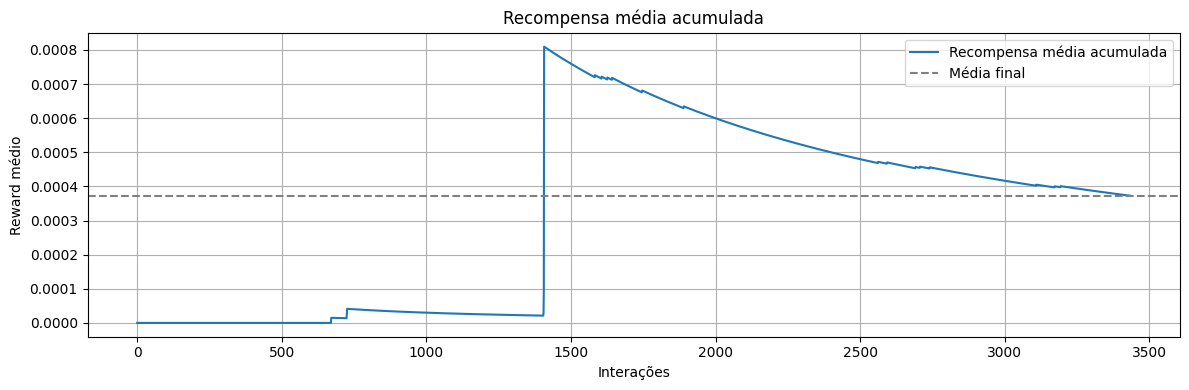

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df_resultado_usuario['reward'].expanding().mean(), label='Recompensa média acumulada')
plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa média acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

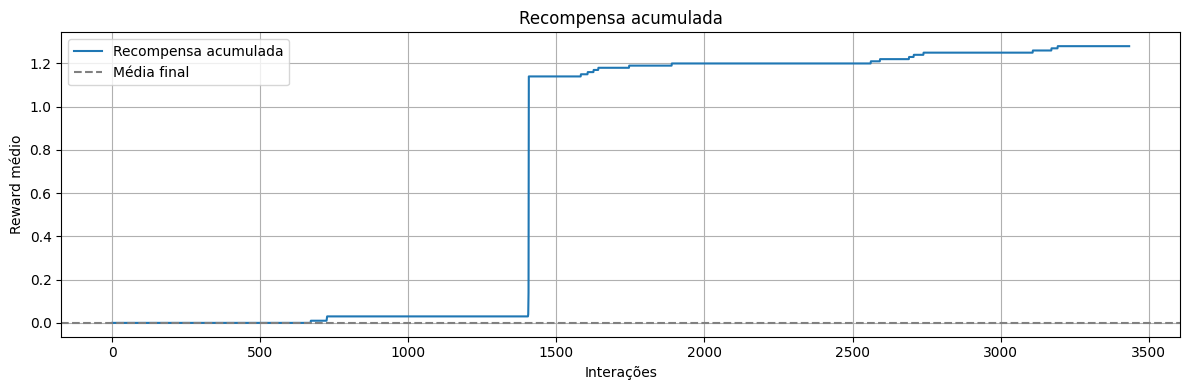

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df_resultado_usuario['reward'].expanding().sum(), label='Recompensa acumulada')
plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

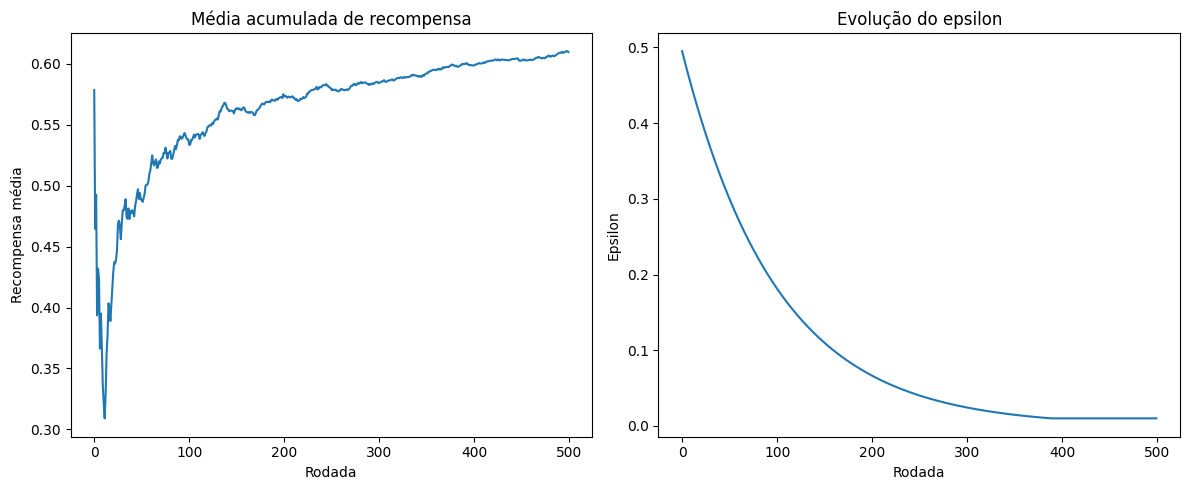

In [ ]:
# Simulação simplificada
def run_simulation(bandit, candidate_items_contexts_list, true_rewards_func, n_rounds=500):
    rewards_history = []
    epsilon_history = []

    for t in range(n_rounds):
        candidate_items_contexts = candidate_items_contexts_list[t]
        # Seleciona item pelo bandit
        chosen_item = bandit.select_item(candidate_items_contexts)
        context = candidate_items_contexts[chosen_item]
        
        # Recebe recompensa verdadeira (simulada)
        reward = true_rewards_func(chosen_item, context)
        
        # Atualiza o bandit
        bandit.update(chosen_item, context, reward)
        
        # Armazena estatísticas
        rewards_history.append(reward)
        epsilon_history.append(bandit.epsilon)

    return rewards_history, epsilon_history

# Exemplo de função verdadeira de recompensa (componente estocástico)
def true_rewards_func(item_id, context_vector):
    # Supomos um vetor de pesos verdadeiros (desconhecidos para o bandit)
    true_weights = {
        'item1': np.array([0.5, 0.3]),
        'item2': np.array([0.2, 0.8]),
        'item3': np.array([0.9, -0.1]),
    }
    mean_reward = np.dot(true_weights[item_id], context_vector)
    # Recompensa com ruído normal
    return np.random.normal(mean_reward, 0.1)

# Exemplo de contexto por rodada (pode variar a cada rodada)
np.random.seed(42)
candidate_items_contexts_list = []
for _ in range(500):
    candidate_items_contexts_list.append({
        'item1': np.random.rand(2),
        'item2': np.random.rand(2),
        'item3': np.random.rand(2),
    })

# Inicializa bandit com epsilon inicial 0.5, decaimento 0.99, min 0.01
bandit = EpsilonGreedy(epsilon=0.5, n_features=2, epsilon_decay=0.99, min_epsilon=0.01)

rewards, epsilons = run_simulation(bandit, candidate_items_contexts_list, true_rewards_func, n_rounds=500)

# Plotando resultados
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(np.cumsum(rewards) / (np.arange(len(rewards)) + 1))
plt.title("Média acumulada de recompensa")
plt.xlabel("Rodada")
plt.ylabel("Recompensa média")

plt.subplot(1, 2, 2)
plt.plot(epsilons)
plt.title("Evolução do epsilon")
plt.xlabel("Rodada")
plt.ylabel("Epsilon")

plt.tight_layout()
plt.show()

# Tests

In [88]:
#
prop_test = properties[properties['property']=='categoryid']
prop_test['timestamp'] = pd.to_datetime(prop_test['timestamp'], unit='ms', origin='unix')
events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms', origin='unix')

C:\Users\fldam\AppData\Local\Temp\ipykernel_12384\4038205902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_test['timestamp'] = pd.to_datetime(prop_test['timestamp'], unit='ms', origin='unix')


In [89]:
# Verifying the event distribution for the most frequent visitor
events[events['visitorid'] == events['visitorid'].value_counts().index[0]]['event'].value_counts()

event
view           6479
addtocart       719
transaction     559
Name: count, dtype: int64

In [117]:
maxvisitor_events = events[events['visitorid'] == events['visitorid'].value_counts().index[1]]
maxvisitor_events

,timestamp,visitorid,event,itemid,transactionid
261793,2015-06-16 00:13:01.237,530559,view,371551,NaN
263557,2015-06-15 20:02:25.898,530559,view,21988,NaN
263568,2015-06-15 19:36:51.103,530559,transaction,362858,14083.0
263581,2015-06-15 19:36:51.103,530559,transaction,439963,14083.0
263739,2015-06-15 19:05:08.755,530559,view,360487,NaN
...,...,...,...,...,...
2735877,2015-07-30 20:06:10.165,530559,addtocart,450930,NaN
2735942,2015-07-30 20:16:53.560,530559,view,206673,NaN
2735957,2015-07-30 20:20:04.709,530559,view,242152,NaN
2736680,2015-07-30 19:19:18.387,530559,view,348495,NaN


In [91]:
merged = maxvisitor_events.merge(prop_test, on='itemid', how='left')
validos = merged[merged['timestamp_y'] <= merged['timestamp_x']].copy()

validos['time_diff'] = (validos['timestamp_x'] - validos['timestamp_y'])

resultado = validos.loc[validos.groupby(['itemid', 'timestamp_x'])['time_diff'].idxmin()].reset_index(drop=True)
resultado.drop(columns=['timestamp_y', 'time_diff', 'property'], inplace=True)
resultado

,timestamp_x,visitorid,event,itemid,transactionid,value
0,2015-08-04 00:17:36.958,1150086,view,25,NaN,1509
1,2015-08-04 00:18:37.279,1150086,view,25,NaN,1509
2,2015-08-13 17:06:21.336,1150086,view,42,NaN,84
3,2015-08-17 22:27:17.339,1150086,view,388,NaN,1258
4,2015-08-20 16:44:16.577,1150086,view,546,NaN,1349
...,...,...,...,...,...,...
6204,2015-07-15 23:29:42.681,1150086,view,466152,NaN,1120
6205,2015-06-19 19:31:09.709,1150086,view,466319,NaN,1254
6206,2015-06-19 19:33:36.581,1150086,view,466319,NaN,1254
6207,2015-06-21 02:03:14.495,1150086,view,466614,NaN,35


In [92]:
# Transform column 'value' into a list of integers
resultado['value'] = resultado['value'].apply(lambda x: int(x))

In [93]:
# Retrieving all rows from cat_tree where any column contains the value of frstitem
cat_tree[cat_tree.isin([1509]).any(axis=1)]

,root,layer_1,layer_2,layer_3,layer_4,layer_5
1584,140.0,540.0,1515.0,620.0,1509.0,NaN


In [94]:
cat_tree['_cat_id'] = cat_tree.index

categorias_long = cat_tree.melt(
    id_vars=['_cat_id'], 
    value_vars=['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5'],
    var_name='layer',
    value_name='value'
)
categorias_long = categorias_long.dropna(subset=['value']).drop_duplicates(subset=['value'])
mapa_categoria = categorias_long.set_index('value')['_cat_id'].to_dict()
resultado['_cat_id'] = resultado['value'].map(mapa_categoria)

resultado_final = resultado.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
resultado_final

,timestamp_x,visitorid,event,itemid,transactionid,value,root,layer_1,layer_2,layer_3,layer_4,layer_5
0,2015-08-04 00:17:36.958,1150086,view,25,NaN,1509,140.0,540.0,1515.0,620.0,1509.0,NaN
1,2015-08-04 00:18:37.279,1150086,view,25,NaN,1509,140.0,540.0,1515.0,620.0,1509.0,NaN
2,2015-08-13 17:06:21.336,1150086,view,42,NaN,84,140.0,1519.0,1308.0,84.0,NaN,NaN
3,2015-08-17 22:27:17.339,1150086,view,388,NaN,1258,140.0,540.0,745.0,1386.0,1258.0,NaN
4,2015-08-20 16:44:16.577,1150086,view,546,NaN,1349,140.0,540.0,121.0,1349.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6204,2015-07-15 23:29:42.681,1150086,view,466152,NaN,1120,250.0,1120.0,552.0,NaN,NaN,NaN
6205,2015-06-19 19:31:09.709,1150086,view,466319,NaN,1254,1600.0,1684.0,1606.0,520.0,1254.0,NaN
6206,2015-06-19 19:33:36.581,1150086,view,466319,NaN,1254,1600.0,1684.0,1606.0,520.0,1254.0,NaN
6207,2015-06-21 02:03:14.495,1150086,view,466614,NaN,35,1532.0,1299.0,20.0,35.0,NaN,NaN


In [95]:
cat_tree.sort_values(by=['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5']).head()

,root,layer_1,layer_2,layer_3,layer_4,layer_5,_cat_id
1151,140.0,61.0,323.0,1558.0,NaN,NaN,1151
760,140.0,61.0,323.0,NaN,NaN,NaN,760
1153,140.0,61.0,897.0,120.0,NaN,NaN,1153
1007,140.0,61.0,897.0,1098.0,NaN,NaN,1007
1528,140.0,61.0,897.0,1317.0,NaN,NaN,1528


In [96]:
resultado_final['root'] = np.nan_to_num(resultado_final['root'])
resultado_final['layer_1'] = np.nan_to_num(resultado_final['layer_1'])
resultado_final['layer_2'] = np.nan_to_num(resultado_final['layer_2'])
resultado_final['layer_3'] = np.nan_to_num(resultado_final['layer_3'])
resultado_final['layer_4'] = np.nan_to_num(resultado_final['layer_4'])
resultado_final['layer_5'] = np.nan_to_num(resultado_final['layer_5'])

In [97]:
# Transform 'root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5' columns from resultado_final into a single vector
resultado_final['context'] = resultado_final.apply(lambda row: \
                                                             [row['root'],row['layer_1'],row['layer_2'], \
                                                              row['layer_3'], row['layer_4'], row['layer_5']], axis=1)

In [98]:
context_events = resultado_final[['timestamp_x', 'itemid','context', 'event']].rename(columns={'timestamp_x': 'timestamp'})

In [99]:
context_events['context'] = context_events['context'].apply(lambda x: np.array(x))
context_events

,timestamp,itemid,context,event
0,2015-08-04 00:17:36.958,25,"[140.0, 540.0, 1515.0, 620.0, 1509.0, 0.0]",view
1,2015-08-04 00:18:37.279,25,"[140.0, 540.0, 1515.0, 620.0, 1509.0, 0.0]",view
2,2015-08-13 17:06:21.336,42,"[140.0, 1519.0, 1308.0, 84.0, 0.0, 0.0]",view
3,2015-08-17 22:27:17.339,388,"[140.0, 540.0, 745.0, 1386.0, 1258.0, 0.0]",view
4,2015-08-20 16:44:16.577,546,"[140.0, 540.0, 121.0, 1349.0, 0.0, 0.0]",view
...,...,...,...,...
6204,2015-07-15 23:29:42.681,466152,"[250.0, 1120.0, 552.0, 0.0, 0.0, 0.0]",view
6205,2015-06-19 19:31:09.709,466319,"[1600.0, 1684.0, 1606.0, 520.0, 1254.0, 0.0]",view
6206,2015-06-19 19:33:36.581,466319,"[1600.0, 1684.0, 1606.0, 520.0, 1254.0, 0.0]",view
6207,2015-06-21 02:03:14.495,466614,"[1532.0, 1299.0, 20.0, 35.0, 0.0, 0.0]",view


In [100]:
# Transform every row in cat_tree into a vector
def vectorize_categories(cat_tree):
    vectors = []
    for _, row in cat_tree.iterrows():
        vector = []
        for col in ['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5']:
            vector.append(row[col])
        vectors.append(vector)
    return np.array(vectors)

In [101]:
cat_vectors = vectorize_categories(cat_tree)
cat_vectors = np.nan_to_num(cat_vectors)
cat_vectors

array([[ 140.,   61.,  323., 1558.,    0.,    0.],
       [ 140.,   61.,  323.,    0.,    0.,    0.],
       [ 140.,   61.,  897.,  120.,    0.,    0.],
       ...,
       [1698., 1678., 1346.,    0.,    0.,    0.],
       [1698., 1678., 1554.,    0.,    0.,    0.],
       [1698., 1678.,    0.,    0.,    0.,    0.]], shape=(1644, 6))

In [102]:
rec_items_test = prop_test[prop_test['itemid'].isin(rec_items)]
rec_items_test

,timestamp,itemid,property,value
1441,2015-05-10 03:00:00,38175,categoryid,196
5312,2015-05-10 03:00:00,285055,categoryid,1167
5914,2015-06-28 03:00:00,172842,categoryid,366
6779,2015-05-31 03:00:00,14741,categoryid,1147
7554,2015-06-28 03:00:00,282528,categoryid,366
...,...,...,...,...
20267695,2015-05-17 03:00:00,439085,categoryid,1680
20269317,2015-08-23 03:00:00,158666,categoryid,491
20272305,2015-05-31 03:00:00,150857,categoryid,1135
20274777,2015-06-28 03:00:00,66046,categoryid,1359


In [103]:
prop_test['value'] = prop_test['value'].apply(lambda x: int(x))

prop_test['_cat_id'] = prop_test['value'].map(mapa_categoria)

prop_test = prop_test.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
prop_test

C:\Users\fldam\AppData\Local\Temp\ipykernel_12384\1077142576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_test['value'] = prop_test['value'].apply(lambda x: int(x))
C:\Users\fldam\AppData\Local\Temp\ipykernel_12384\1077142576.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prop_test['_cat_id'] = prop_test['value'].map(mapa_categoria)


,timestamp,itemid,property,value,root,layer_1,layer_2,layer_3,layer_4,layer_5
0,2015-06-28 03:00:00,460429,categoryid,1338,395.0,1278.0,1338.0,NaN,NaN,NaN
1,2015-05-24 03:00:00,281245,categoryid,1277,653.0,312.0,1277.0,NaN,NaN,NaN
2,2015-06-28 03:00:00,35575,categoryid,1059,378.0,1696.0,1059.0,NaN,NaN,NaN
3,2015-07-19 03:00:00,8313,categoryid,1147,250.0,1027.0,1147.0,NaN,NaN,NaN
4,2015-07-26 03:00:00,55102,categoryid,47,1482.0,381.0,47.0,423.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
788209,2015-06-07 03:00:00,255696,categoryid,1404,1482.0,593.0,1404.0,NaN,NaN,NaN
788210,2015-05-10 03:00:00,390760,categoryid,324,1532.0,113.0,1145.0,324.0,NaN,NaN
788211,2015-07-26 03:00:00,211844,categoryid,256,395.0,1257.0,256.0,NaN,NaN,NaN
788212,2015-06-28 03:00:00,444741,categoryid,511,250.0,724.0,511.0,NaN,NaN,NaN


In [104]:
cat_tree['_cat_id'] = cat_tree.index

categorias_long = cat_tree.melt(
    id_vars=['_cat_id'], 
    value_vars=['root', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5'],
    var_name='layer',
    value_name='value'
)
categorias_long = categorias_long.dropna(subset=['value']).drop_duplicates(subset=['value'])
mapa_categoria = categorias_long.set_index('value')['_cat_id'].to_dict()

rec_items_test['value'] = rec_items_test['value'].apply(lambda x: int(x))

rec_items_test['_cat_id'] = rec_items_test['value'].map(mapa_categoria)

rec_items_test = rec_items_test.merge(cat_tree, on='_cat_id', how='left').drop(columns=['_cat_id'])
rec_items_test

,timestamp,itemid,property,value,root,layer_1,layer_2,layer_3,layer_4,layer_5
0,2015-05-10 03:00:00,38175,categoryid,196,140.0,409.0,1667.0,196.0,NaN,NaN
1,2015-05-10 03:00:00,285055,categoryid,1167,250.0,1167.0,NaN,NaN,NaN,NaN
2,2015-06-28 03:00:00,172842,categoryid,366,1482.0,143.0,366.0,NaN,NaN,NaN
3,2015-05-31 03:00:00,14741,categoryid,1147,250.0,1027.0,1147.0,NaN,NaN,NaN
4,2015-06-28 03:00:00,282528,categoryid,366,1482.0,143.0,366.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
10414,2015-05-17 03:00:00,439085,categoryid,1680,791.0,587.0,1680.0,NaN,NaN,NaN
10415,2015-08-23 03:00:00,158666,categoryid,491,679.0,491.0,NaN,NaN,NaN,NaN
10416,2015-05-31 03:00:00,150857,categoryid,1135,140.0,1519.0,1329.0,1135.0,NaN,NaN
10417,2015-06-28 03:00:00,66046,categoryid,1359,679.0,1424.0,1215.0,1359.0,NaN,NaN


In [105]:
prop_test['root'] = np.nan_to_num(prop_test['root'])
prop_test['layer_1'] = np.nan_to_num(prop_test['layer_1'])
prop_test['layer_2'] = np.nan_to_num(prop_test['layer_2'])
prop_test['layer_3'] = np.nan_to_num(prop_test['layer_3'])
prop_test['layer_4'] = np.nan_to_num(prop_test['layer_4'])
prop_test['layer_5'] = np.nan_to_num(prop_test['layer_5'])

prop_test['context'] = prop_test.apply(lambda row: \
                                                             [row['root'],row['layer_1'],row['layer_2'], \
                                                              row['layer_3'], row['layer_4'], row['layer_5']], axis=1)
prop_test

,timestamp,itemid,property,value,root,layer_1,layer_2,layer_3,layer_4,layer_5,context
0,2015-06-28 03:00:00,460429,categoryid,1338,395.0,1278.0,1338.0,0.0,0.0,0.0,"[395.0, 1278.0, 1338.0, 0.0, 0.0, 0.0]"
1,2015-05-24 03:00:00,281245,categoryid,1277,653.0,312.0,1277.0,0.0,0.0,0.0,"[653.0, 312.0, 1277.0, 0.0, 0.0, 0.0]"
2,2015-06-28 03:00:00,35575,categoryid,1059,378.0,1696.0,1059.0,0.0,0.0,0.0,"[378.0, 1696.0, 1059.0, 0.0, 0.0, 0.0]"
3,2015-07-19 03:00:00,8313,categoryid,1147,250.0,1027.0,1147.0,0.0,0.0,0.0,"[250.0, 1027.0, 1147.0, 0.0, 0.0, 0.0]"
4,2015-07-26 03:00:00,55102,categoryid,47,1482.0,381.0,47.0,423.0,0.0,0.0,"[1482.0, 381.0, 47.0, 423.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...
788209,2015-06-07 03:00:00,255696,categoryid,1404,1482.0,593.0,1404.0,0.0,0.0,0.0,"[1482.0, 593.0, 1404.0, 0.0, 0.0, 0.0]"
788210,2015-05-10 03:00:00,390760,categoryid,324,1532.0,113.0,1145.0,324.0,0.0,0.0,"[1532.0, 113.0, 1145.0, 324.0, 0.0, 0.0]"
788211,2015-07-26 03:00:00,211844,categoryid,256,395.0,1257.0,256.0,0.0,0.0,0.0,"[395.0, 1257.0, 256.0, 0.0, 0.0, 0.0]"
788212,2015-06-28 03:00:00,444741,categoryid,511,250.0,724.0,511.0,0.0,0.0,0.0,"[250.0, 724.0, 511.0, 0.0, 0.0, 0.0]"


In [106]:
rec_items_test['root'] = np.nan_to_num(rec_items_test['root'])
rec_items_test['layer_1'] = np.nan_to_num(rec_items_test['layer_1'])
rec_items_test['layer_2'] = np.nan_to_num(rec_items_test['layer_2'])
rec_items_test['layer_3'] = np.nan_to_num(rec_items_test['layer_3'])
rec_items_test['layer_4'] = np.nan_to_num(rec_items_test['layer_4'])
rec_items_test['layer_5'] = np.nan_to_num(rec_items_test['layer_5'])

rec_items_test['context'] = rec_items_test.apply(lambda row: \
                                                             [row['root'],row['layer_1'],row['layer_2'], \
                                                              row['layer_3'], row['layer_4'], row['layer_5']], axis=1)
rec_items_test

,timestamp,itemid,property,value,root,layer_1,layer_2,layer_3,layer_4,layer_5,context
0,2015-05-10 03:00:00,38175,categoryid,196,140.0,409.0,1667.0,196.0,0.0,0.0,"[140.0, 409.0, 1667.0, 196.0, 0.0, 0.0]"
1,2015-05-10 03:00:00,285055,categoryid,1167,250.0,1167.0,0.0,0.0,0.0,0.0,"[250.0, 1167.0, 0.0, 0.0, 0.0, 0.0]"
2,2015-06-28 03:00:00,172842,categoryid,366,1482.0,143.0,366.0,0.0,0.0,0.0,"[1482.0, 143.0, 366.0, 0.0, 0.0, 0.0]"
3,2015-05-31 03:00:00,14741,categoryid,1147,250.0,1027.0,1147.0,0.0,0.0,0.0,"[250.0, 1027.0, 1147.0, 0.0, 0.0, 0.0]"
4,2015-06-28 03:00:00,282528,categoryid,366,1482.0,143.0,366.0,0.0,0.0,0.0,"[1482.0, 143.0, 366.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...
10414,2015-05-17 03:00:00,439085,categoryid,1680,791.0,587.0,1680.0,0.0,0.0,0.0,"[791.0, 587.0, 1680.0, 0.0, 0.0, 0.0]"
10415,2015-08-23 03:00:00,158666,categoryid,491,679.0,491.0,0.0,0.0,0.0,0.0,"[679.0, 491.0, 0.0, 0.0, 0.0, 0.0]"
10416,2015-05-31 03:00:00,150857,categoryid,1135,140.0,1519.0,1329.0,1135.0,0.0,0.0,"[140.0, 1519.0, 1329.0, 1135.0, 0.0, 0.0]"
10417,2015-06-28 03:00:00,66046,categoryid,1359,679.0,1424.0,1215.0,1359.0,0.0,0.0,"[679.0, 1424.0, 1215.0, 1359.0, 0.0, 0.0]"


In [107]:
prop_test = prop_test[['timestamp', 'itemid','context']]
prop_test

,timestamp,itemid,context
0,2015-06-28 03:00:00,460429,"[395.0, 1278.0, 1338.0, 0.0, 0.0, 0.0]"
1,2015-05-24 03:00:00,281245,"[653.0, 312.0, 1277.0, 0.0, 0.0, 0.0]"
2,2015-06-28 03:00:00,35575,"[378.0, 1696.0, 1059.0, 0.0, 0.0, 0.0]"
3,2015-07-19 03:00:00,8313,"[250.0, 1027.0, 1147.0, 0.0, 0.0, 0.0]"
4,2015-07-26 03:00:00,55102,"[1482.0, 381.0, 47.0, 423.0, 0.0, 0.0]"
...,...,...,...
788209,2015-06-07 03:00:00,255696,"[1482.0, 593.0, 1404.0, 0.0, 0.0, 0.0]"
788210,2015-05-10 03:00:00,390760,"[1532.0, 113.0, 1145.0, 324.0, 0.0, 0.0]"
788211,2015-07-26 03:00:00,211844,"[395.0, 1257.0, 256.0, 0.0, 0.0, 0.0]"
788212,2015-06-28 03:00:00,444741,"[250.0, 724.0, 511.0, 0.0, 0.0, 0.0]"


In [108]:
rec_items_test = rec_items_test[['timestamp', 'itemid','context']]

In [109]:
class EpsilonGreedy:
    def __init__(self, epsilon: float, n_features: int, learning_rate: float = 0.1):
        self.epsilon = epsilon
        self.lr = learning_rate
        self.n_features = n_features
        self.weights = {}  # item_id -> vetor de pesos
        
    def _get_weights(self, item_id):
        # Verifica se o item_id já tem pesos, caso contrário inicializa com zeros
        if item_id not in self.weights:
            self.weights[item_id] = np.zeros(self.n_features)
        return self.weights[item_id]
    
    def predict(self, item_id, context_vector):
        weights = self._get_weights(item_id)
        # Normaliza o vetor de contexto para evitar problemas de escala
        context_vector = context_vector / np.linalg.norm(context_vector) if np.linalg.norm(context_vector) > 0 else context_vector
        # Calcula a previsão como o produto escalar entre os pesos e o vetor de contexto
        return np.dot(weights, context_vector)
    
    def select_item(self, candidate_items_contexts):
        if random.random() < self.epsilon:
            return random.choice(list(candidate_items_contexts.keys()))

        scores = {
            item_id: self.predict(item_id, context)
            for item_id, context in candidate_items_contexts.items()
        }
        return max(scores, key=scores.get)
        
    def update(self, item_id, context_vector, reward):
        weights = self._get_weights(item_id)
        prediction = self.predict(item_id, context_vector)
        error = reward - prediction
        self.weights[item_id] += self.lr * error * context_vector

In [110]:
def simular_recomendacao_top5_epsilon_greedy(df_merged, catalogo_df, model, top_k=5, warmup=30):
    historico = []

    # Converte contextos para np.array
    df_merged['context'] = df_merged['context'].apply(lambda x: np.array(x))
    catalogo_df['context'] = catalogo_df['context'].apply(lambda x: np.array(x))

    for i, row in enumerate(df_merged.itertuples(index=False)):
        evento_ts = row.timestamp
        true_item = row.itemid
        contexto_evento = row.context
        tipo_evento = row.event

        reward_val = {'view': 0.1, 'addtocart': 0.5, 'transaction': 1.0}.get(tipo_evento, 0.0)

        # Filtra catálogo disponível até o timestamp do evento
        disponiveis = catalogo_df[catalogo_df['timestamp'] <= evento_ts]
        if disponiveis.empty:
            continue

        # Mapeia itemid -> contexto
        candidatos_context = {
            r['itemid']: np.array(r['context']) for _, r in disponiveis.iterrows()
        }

        if i < warmup:
            # Fase de aprendizado supervisionado
            if true_item in candidatos_context:
                model.update(true_item, contexto_evento, reward_val)
            continue  # Não recomenda nessa fase

        # Calcula scores
        scores = {
            item_id: model.predict(item_id, context)
            for item_id, context in candidatos_context.items()
        }

        # Seleciona top-K itens com maior score
        top_k_items = sorted(scores, key=scores.get, reverse=True)[:top_k]

        # Avalia recompensa total: se true_item está entre os top_k
        recompensa = reward_val if true_item in top_k_items else 0.0
        # Atualiza modelo com todos os top_k itens
        for item_id in top_k_items:
            r = reward_val if item_id == true_item else 0.0
            model.update(item_id, candidatos_context[item_id], r)
        # Aprendizado supervisionado adicional com true_item (se disponível)
        if true_item in candidatos_context:
            model.update(true_item, candidatos_context[true_item], reward_val)

        historico.append({
            'timestamp': evento_ts,
            'true_item': true_item,
            'top_k': top_k_items,
            'reward': recompensa
        })

    return pd.DataFrame(historico)

In [111]:
def simular_recomendacao_top5_epsilon_greedy(df_merged, catalogo_df, model, top_k=5, warmup=30):
    historico = []

    # Converte contextos para np.array
    df_merged['context'] = df_merged['context'].apply(lambda x: np.array(x))
    catalogo_df['context'] = catalogo_df['context'].apply(lambda x: np.array(x))

    for i, row in enumerate(df_merged.itertuples(index=False)):
        evento_ts = row.timestamp
        true_item = row.itemid
        contexto_evento = row.context
        tipo_evento = row.event

        reward_val = {'view': 0.1, 'addtocart': 0.5, 'transaction': 1.0}.get(tipo_evento, 0.0)

        # Filtra catálogo disponível até o timestamp do evento
        disponiveis = catalogo_df[catalogo_df['timestamp'] <= evento_ts]
        if disponiveis.empty:
            continue

        # Mapeia itemid -> contexto
        candidatos_context = {
            r['itemid']: np.array(r['context']) for _, r in disponiveis.iterrows()
        }

        if i < warmup:
            # Fase de aprendizado supervisionado
            if true_item in candidatos_context:
                model.update(true_item, contexto_evento, reward_val)
            continue  # Não recomenda nessa fase

        # Copia dos candidatos para iteração segura
        candidatos_restantes = candidatos_context.copy()
        top_k_items = []

        # Seleção de itens com exploração e exploração
        for _ in range(min(top_k, len(candidatos_restantes))):
            # Usa a função select_item diretamente
            item_escolhido = model.select_item(candidatos_restantes)
            top_k_items.append(item_escolhido)
            candidatos_restantes.pop(item_escolhido)

        # Avalia recompensa total: se true_item está entre os top_k
        recompensa = reward_val if true_item in top_k_items else 0.0
        # Atualiza modelo com todos os top_k itens
        for item_id in top_k_items:
            r = reward_val if item_id == true_item else 0.0
            model.update(item_id, candidatos_context[item_id], r)
        # Aprendizado supervisionado adicional com true_item (se disponível)
        if true_item in candidatos_context:
            model.update(true_item, candidatos_context[true_item], reward_val)

        historico.append({
            'timestamp': evento_ts,
            'true_item': true_item,
            'top_k': top_k_items,
            'reward': recompensa
        })

    return pd.DataFrame(historico)

In [112]:
context_events.sort_values(by='timestamp', inplace=True)

In [113]:
rec_items_test = rec_items_test[rec_items_test['timestamp'] <= context_events['timestamp'].max()].sort_values(by='timestamp')

In [ ]:
# Instancia o modelo
n_features = len(context_events.iloc[0]['context'])
modelo_usuario = EpsilonGreedy(epsilon=0.3, n_features=n_features)

# Simula
df_resultado_usuario = simular_recomendacao_top5_epsilon_greedy(context_events, rec_items_test, modelo_usuario)

In [114]:
context_events['event'].value_counts()

event
view           5053
addtocart       652
transaction     504
Name: count, dtype: int64

In [164]:
df_resultado_usuario['reward'].value_counts().sort_index()

reward
0.0    4800
0.1     559
0.5     456
1.0     364
Name: count, dtype: int64

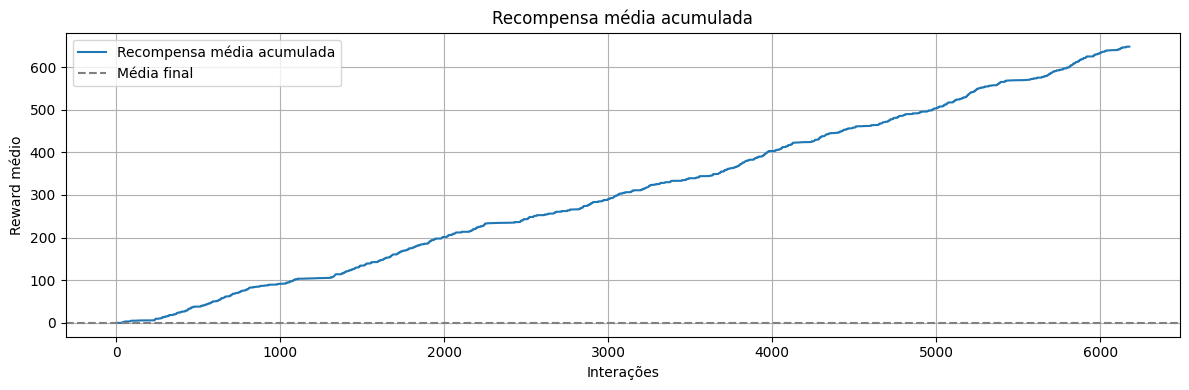

In [156]:
plt.figure(figsize=(12, 4))
plt.plot(df_resultado_usuario['reward'].cumsum(), label='Recompensa média acumulada')
plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa média acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

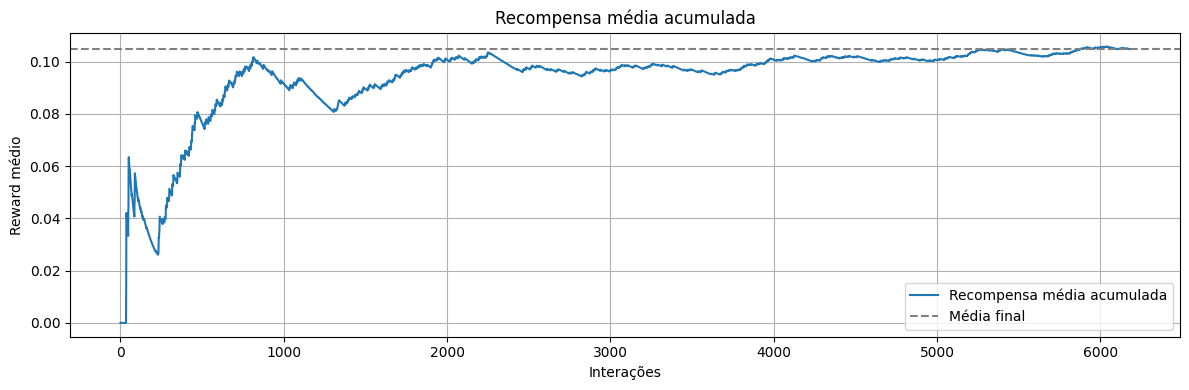

In [149]:
plt.figure(figsize=(12, 4))
plt.plot(df_resultado_usuario['reward'].expanding().mean(), label='Recompensa média acumulada')
plt.axhline(df_resultado_usuario['reward'].mean(), color='gray', linestyle='--', label='Média final')
plt.title(f'Recompensa média acumulada')
plt.xlabel('Interações')
plt.ylabel('Reward médio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [150]:
weights = modelo_usuario.weights
weights_df = pd.DataFrame.from_dict(weights, orient='index')
weights_df

,0,1,2,3,4,5
231726,-4.117064e+12,-6.907826e+10,-3.484307e+12,0.000000e+00,0.000000e+00,0.0
427777,-6.403016e+06,-1.870596e+07,-5.008074e+07,-4.386066e+07,-3.178640e+07,0.0
458489,-3.114246e+07,-2.671534e+06,-1.572389e+07,0.000000e+00,0.000000e+00,0.0
357133,-2.107716e+22,-2.969524e+21,-2.056073e+22,0.000000e+00,0.000000e+00,0.0
340578,-2.172540e+13,-2.286598e+13,-7.875457e+12,-1.636194e+13,0.000000e+00,0.0
...,...,...,...,...,...,...
128602,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
21757,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
223958,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
336069,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
